In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

In [2]:
rna_adata = anndata.concat(
    [sc.read_csv(f"../../data/scRNAseq/MouseLiver/SCP2045/expression/processed_{sub}.csv.gz").T.copy() for sub in ['s1', 's2', 'c1', 'c2']], join="inner")
rna_adata.obs = pd.read_csv("../../data/scRNAseq/MouseLiver/SCP2045/metadata/meta_data_manual.csv", index_col=0).loc[rna_adata.obs_names]
rna_adata.obsm['X_umap'] = pd.read_csv("../../data/scRNAseq/MouseLiver/SCP2045/cluster/clustering_manual.csv", index_col=0).loc[rna_adata.obs_names][["X", "Y"]].values.astype(np.float32)
rna_adata.obs['celltype'] = pd.read_csv("../../data/scRNAseq/MouseLiver/SCP2045/cluster/clustering_manual.csv", index_col=0).loc[rna_adata.obs_names]["Category"].values

sc.pp.highly_variable_genes(rna_adata)
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
rna_adata

AnnData object with n_obs × n_vars = 11085 × 3907
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_umap'

In [3]:
spa_adata = anndata.concat(
    [sc.read_csv(f"../../data/ST/MouseLiver/SCP2046/expression/processed_{sub}.csv.gz").T.copy() for sub in ['s1', 's2', 'c1', 'c2']], join="inner")
spa_adata.obs = pd.read_csv("../../data/ST/MouseLiver/SCP2046/metadata/meta_data.csv", index_col=0).loc[spa_adata.obs_names]
spa_adata.obsm['X_umap'] = pd.read_csv("../../data/ST/MouseLiver/SCP2046/cluster/clustering.csv", index_col=0).loc[spa_adata.obs_names][["X", "Y"]].values.astype(np.float32)
spa_adata.obs['celltype'] = pd.read_csv("../../data/ST/MouseLiver/SCP2046/cluster/clustering.csv", index_col=0).loc[spa_adata.obs_names]["Category"].values
spa_adata.obsm['spatial'] = pd.concat([pd.read_csv(f"../../data/ST/MouseLiver/SCP2046/cluster/spatial_{sb}.csv", index_col=0).iloc[1:] for sb in ['s1', 's2', 'c1', 'c2']], axis=0).loc[spa_adata.obs_names].values.astype(np.float32)
pd.DataFrame(spa_adata.obsm['spatial'], columns=['x','y']).to_csv("../../output/locations/mouseliver.csv", index=False)
spa_adata

AnnData object with n_obs × n_vars = 7758 × 16225
    obs: 'biosample_id', 'zones', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
    obsm: 'X_umap', 'spatial'

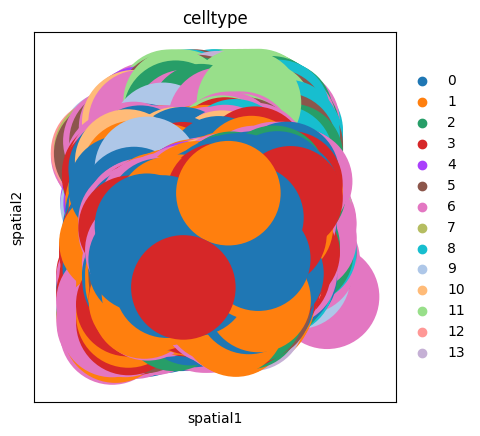

In [4]:
sc.pl.spatial(spa_adata, color='celltype', spot_size=200)

In [5]:
sq.gr.spatial_neighbors(spa_adata, coord_type='grid', n_neighs=6)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)

In [6]:
classes, ct_list = leiden_cluster(rna_adata, False)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
rna_adata, spa_adata


(AnnData object with n_obs × n_vars = 11085 × 3907
     obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype', 'leiden'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'hvg'
     obsm: 'X_umap',
 AnnData object with n_obs × n_vars = 7758 × 16225
     obs: 'biosample_id', 'zones', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
     uns: 'celltype_colors', 'spatial_neighbors', 'moranI'
     obsm: 'X_umap', 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [7]:
raw_spatial_df  = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((7758, 16225), (11085, 3907), (3743,))

In [8]:
spa_adata.uns['moranI']

,I,pval_norm,var_norm,pval_norm_fdr_bh
Ccdc152,0.094741,0.000000e+00,0.000078,0.000000e+00
Nphp4,0.076155,0.000000e+00,0.000078,0.000000e+00
Ptprr,0.073506,0.000000e+00,0.000078,0.000000e+00
Gm17134,0.070558,6.661338e-16,0.000078,1.501114e-14
Ccdc114,0.069642,1.443290e-15,0.000078,3.212261e-14
...,...,...,...,...
Saa1,-0.346865,0.000000e+00,0.000078,0.000000e+00
Apcs,-0.350344,0.000000e+00,0.000078,0.000000e+00
Saa2,-0.354392,0.000000e+00,0.000078,0.000000e+00
Mt2,-0.362502,0.000000e+00,0.000078,0.000000e+00


In [9]:
spa_shared = spa_adata[:, raw_shared_gene].copy()
rna_shared = rna_adata[:, raw_shared_gene].copy()
raw_spatial_df  = pd.DataFrame(spa_shared.X, columns=spa_shared.var_names)
raw_scrna_df    = pd.DataFrame(rna_shared.X, columns=rna_shared.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((7758, 3743), (11085, 3743), (3743,))

In [10]:
np.random.seed(42)
neg_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values >= 0.01], 50, replace=False)
pos_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values < 0.01], 50, replace=False)

train_gene = np.union1d(pos_genes, neg_genes)
test_gene = np.setdiff1d(raw_shared_gene, train_gene)
len(np.unique(train_gene)), len(test_gene)

(100, 3643)

In [11]:
df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)

# for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
print(f"\n==========\nNumber of train genes: {len(train_gene)}, Number of test genes: {len(test_gene)}")

test_spatial_df = raw_spatial_df[test_gene]
spatial_df = raw_spatial_df[train_gene]
scrna_df   = raw_scrna_df

df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        n_epochs=2500,
        clip_max=2,
        wt_spa=1,
        # mapping_lowdim=128,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

df_transImpCls[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        n_epochs=2500,
        signature_mode='cluster',
        mapping_mode='full',
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

df_transImp[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        n_epochs=2500,
        mapping_mode='lowrank',
        clip_max=2,
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

df_transImpClsSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        signature_mode='cluster',
        mapping_mode='full',
        n_epochs=2500,
        wt_spa=1,
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "tmp_stvisp", top_k=100, verbose=False, random_seed=seed, device=device)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
np.median(corr_transImp_res), "(TransImp)", 
np.median(corr_transImpCls_res), "(TransImpCls)", 
np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
np.median(corr_res_stplus), "(stPlus)", 
np.median(corr_res_spaGE), "(spaGE)",
np.median(corr_res_tangram), "(Tangram)"
)


Number of train genes: 100, Number of test genes: 3643


[TransImp] Epoch: 2500/2500, loss: 0.623667, (IMP) 0.623361, (SPA) 1 x 0.000306: 100%|██████████| 2500/2500 [00:11<00:00, 214.69it/s]


Median correlation: 0.08218580172901098 (TransImpSpa)


[TransImp] Epoch: 2500/2500, loss: 0.573507, (IMP) 0.573507, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:05<00:00, 427.27it/s]


Median correlation: 0.10018771279023468 (TransImpCls)


[TransImp] Epoch: 2500/2500, loss: 0.620190, (IMP) 0.620190, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:07<00:00, 321.54it/s]


Median correlation: 0.08115722302553682 (TransImp)


[TransImp] Epoch: 2500/2500, loss: 0.577352, (IMP) 0.574309, (SPA) 1 x 0.003043: 100%|██████████| 2500/2500 [00:08<00:00, 287.72it/s]


Median correlation: 0.09926099387325281 (TransImpClsSpa)
			nan (stPlus)
			0.043105369670272065 (spaGE)


INFO:root:100 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:100 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 100 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.442, KL reg: 0.053
Score: 0.673, KL reg: 0.003
Score: 0.674, KL reg: 0.003
Score: 0.675, KL reg: 0.003
Score: 0.675, KL reg: 0.003
Score: 0.675, KL reg: 0.003
Score: 0.675, KL reg: 0.003
Score: 0.675, KL reg: 0.003
Score: 0.675, KL reg: 0.003


INFO:root:Saving results..


Score: 0.675, KL reg: 0.003
			0.0773246550067797 (Tangram)
0.08218580172901098 (TransImpSpa) 0.08115722302553682 (TransImp) 0.10018771279023468 (TransImpCls) 0.09926099387325281 (TransImpClsSpa) nan (stPlus) 0.043105369670272065 (spaGE) 0.0773246550067797 (Tangram)


In [12]:
df_transImp.to_csv('../../output/mouseliverext_singlecell_transImpute.csv')
df_transImpSpa.to_csv('../../output/mouseliverext_singlecell_transImpSpa.csv')
df_transImpCls.to_csv('../../output/mouseliverext_singlecell_transImpCls.csv')
df_transImpClsSpa.to_csv('../../output/mouseliverext_singlecell_transImpClsSpa.csv')
df_spaGE_res.to_csv('../../output/mouseliverext_singlecell_spaGE.csv')
df_stplus_res.to_csv('../../output/mouseliverext_singlecell_stPlus.csv')
df_tangram_res.to_csv('../../output/mouseliverext_singlecell_Tangram.csv')
test_spatial_df.to_csv('../../output/mouseliverext_singlecell_truth.csv')

In [13]:
dict_df = {
        "TransImp":df_transImp[test_gene], 
           "TransImpSpa":df_transImpSpa[test_gene], 
           "TransImpCls":df_transImpCls[test_gene],
           "TransImpClsSpa":df_transImpClsSpa[test_gene],
           "spaGE": df_spaGE_res[test_gene], 
           "stPlus": df_stplus_res[test_gene], 
           "Tangram":df_tangram_res[test_gene]
        }

dict_adata = {name: compute_autocorr(spa_shared[:, test_gene].copy(), df) for name, df in dict_df.items()}


In [14]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings



with open("../../output/mouseliverext_small_train_genes.pkl", 'wb') as outfile:
    pickle.dump((train_gene, test_gene), outfile)

warnings.filterwarnings('ignore')
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
eval_res_path = "../../output/mouseliverext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01


In [15]:
spa_shared

AnnData object with n_obs × n_vars = 7758 × 3743
    obs: 'biosample_id', 'zones', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
    uns: 'celltype_colors', 'spatial_neighbors', 'moranI'
    obsm: 'X_umap', 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [17]:
if is_reeval:
    spa_adata = spa_shared[:, test_gene].copy()
    df_spa = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)

    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'is_sig':{}, 'I':{}, 'spatialDE_stats':{}, 'spatialDE_qvals':{}}
    for method  in tqdm(['stPlus', 'spaGE', 'Tangram', 'TransImp', 'TransImpSpa', 'TransImpCls', 'TransImpClsSpa']):
   
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        imp_adata = dict_adata[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue

       
        is_sig = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['is_sig'][method] = pd.Series(is_sig, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)


100%|██████████| 7/7 [01:10<00:00, 10.08s/it]


In [18]:
np.unique(spa_adata.uns['moranI'].pval_norm_fdr_bh < .01, return_counts=True)

(array([False,  True]), array([14076,  2149]))

In [19]:

df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_issig     = pd.DataFrame(dict(sorted(eval_res['is_sig'].items())))
df_spatialDE_stats = pd.DataFrame(dict(sorted(eval_res['spatialDE_stats'].items())))
df_spatialDE_pvals = pd.DataFrame(dict(sorted(eval_res['spatialDE_qvals'].items())))

df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_issig['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].I

imp_adatas = dict(sorted(imp_adatas.items()))
df_issig

,Tangram,TransImp,TransImpCls,TransImpClsSpa,TransImpSpa,spaGE,stPlus,truth
0610005C13Rik,1.467275e-06,4.996316e-03,2.908321e-05,0.000000e+00,6.042810e-10,1.796439e-03,NaN,6.903743e-02
0610031O16Rik,1.089694e-05,1.374070e-02,9.309346e-05,0.000000e+00,1.708762e-09,4.573189e-03,NaN,1.231689e-01
1110032A03Rik,3.216812e-04,2.248723e-02,7.757276e-04,0.000000e+00,5.168966e-09,6.552500e-03,NaN,4.896632e-01
1110046J04Rik,4.514611e-04,2.415760e-02,1.519709e-03,0.000000e+00,5.946656e-09,9.096559e-03,NaN,4.909412e-02
1190005I06Rik,4.844638e-04,2.947986e-02,1.571030e-03,0.000000e+00,4.469519e-08,1.318956e-02,NaN,4.565089e-01
...,...,...,...,...,...,...,...,...
Zyg11b,3.126879e-65,5.958463e-44,2.856704e-89,4.928723e-54,9.320612e-59,1.720347e-30,NaN,9.353730e-02
mt-Atp8,8.263046e-67,6.538502e-47,1.111066e-91,2.453682e-54,2.839698e-62,3.581303e-31,NaN,6.785618e-05
mt-Nd2,3.575102e-70,6.204392e-48,1.031759e-92,2.210782e-54,1.664375e-67,3.495517e-33,NaN,1.414675e-14
mt-Nd3,2.820522e-79,6.204392e-48,1.031759e-92,2.210782e-54,6.968498e-99,1.078488e-35,NaN,9.672548e-03


(Tangram) Valid genes: 1190/3643
Tangram
FPR: 0.678298
(TransImp) Valid genes: 1190/3643
TransImp
FPR: 0.914043
(TransImpSpa) Valid genes: 1190/3643
TransImpSpa
FPR: 0.736170
(spaGE) Valid genes: 1190/3643
spaGE
FPR: 0.386383
(stPlus) Valid genes: 894/3643
stPlus
FPR: 0.000000


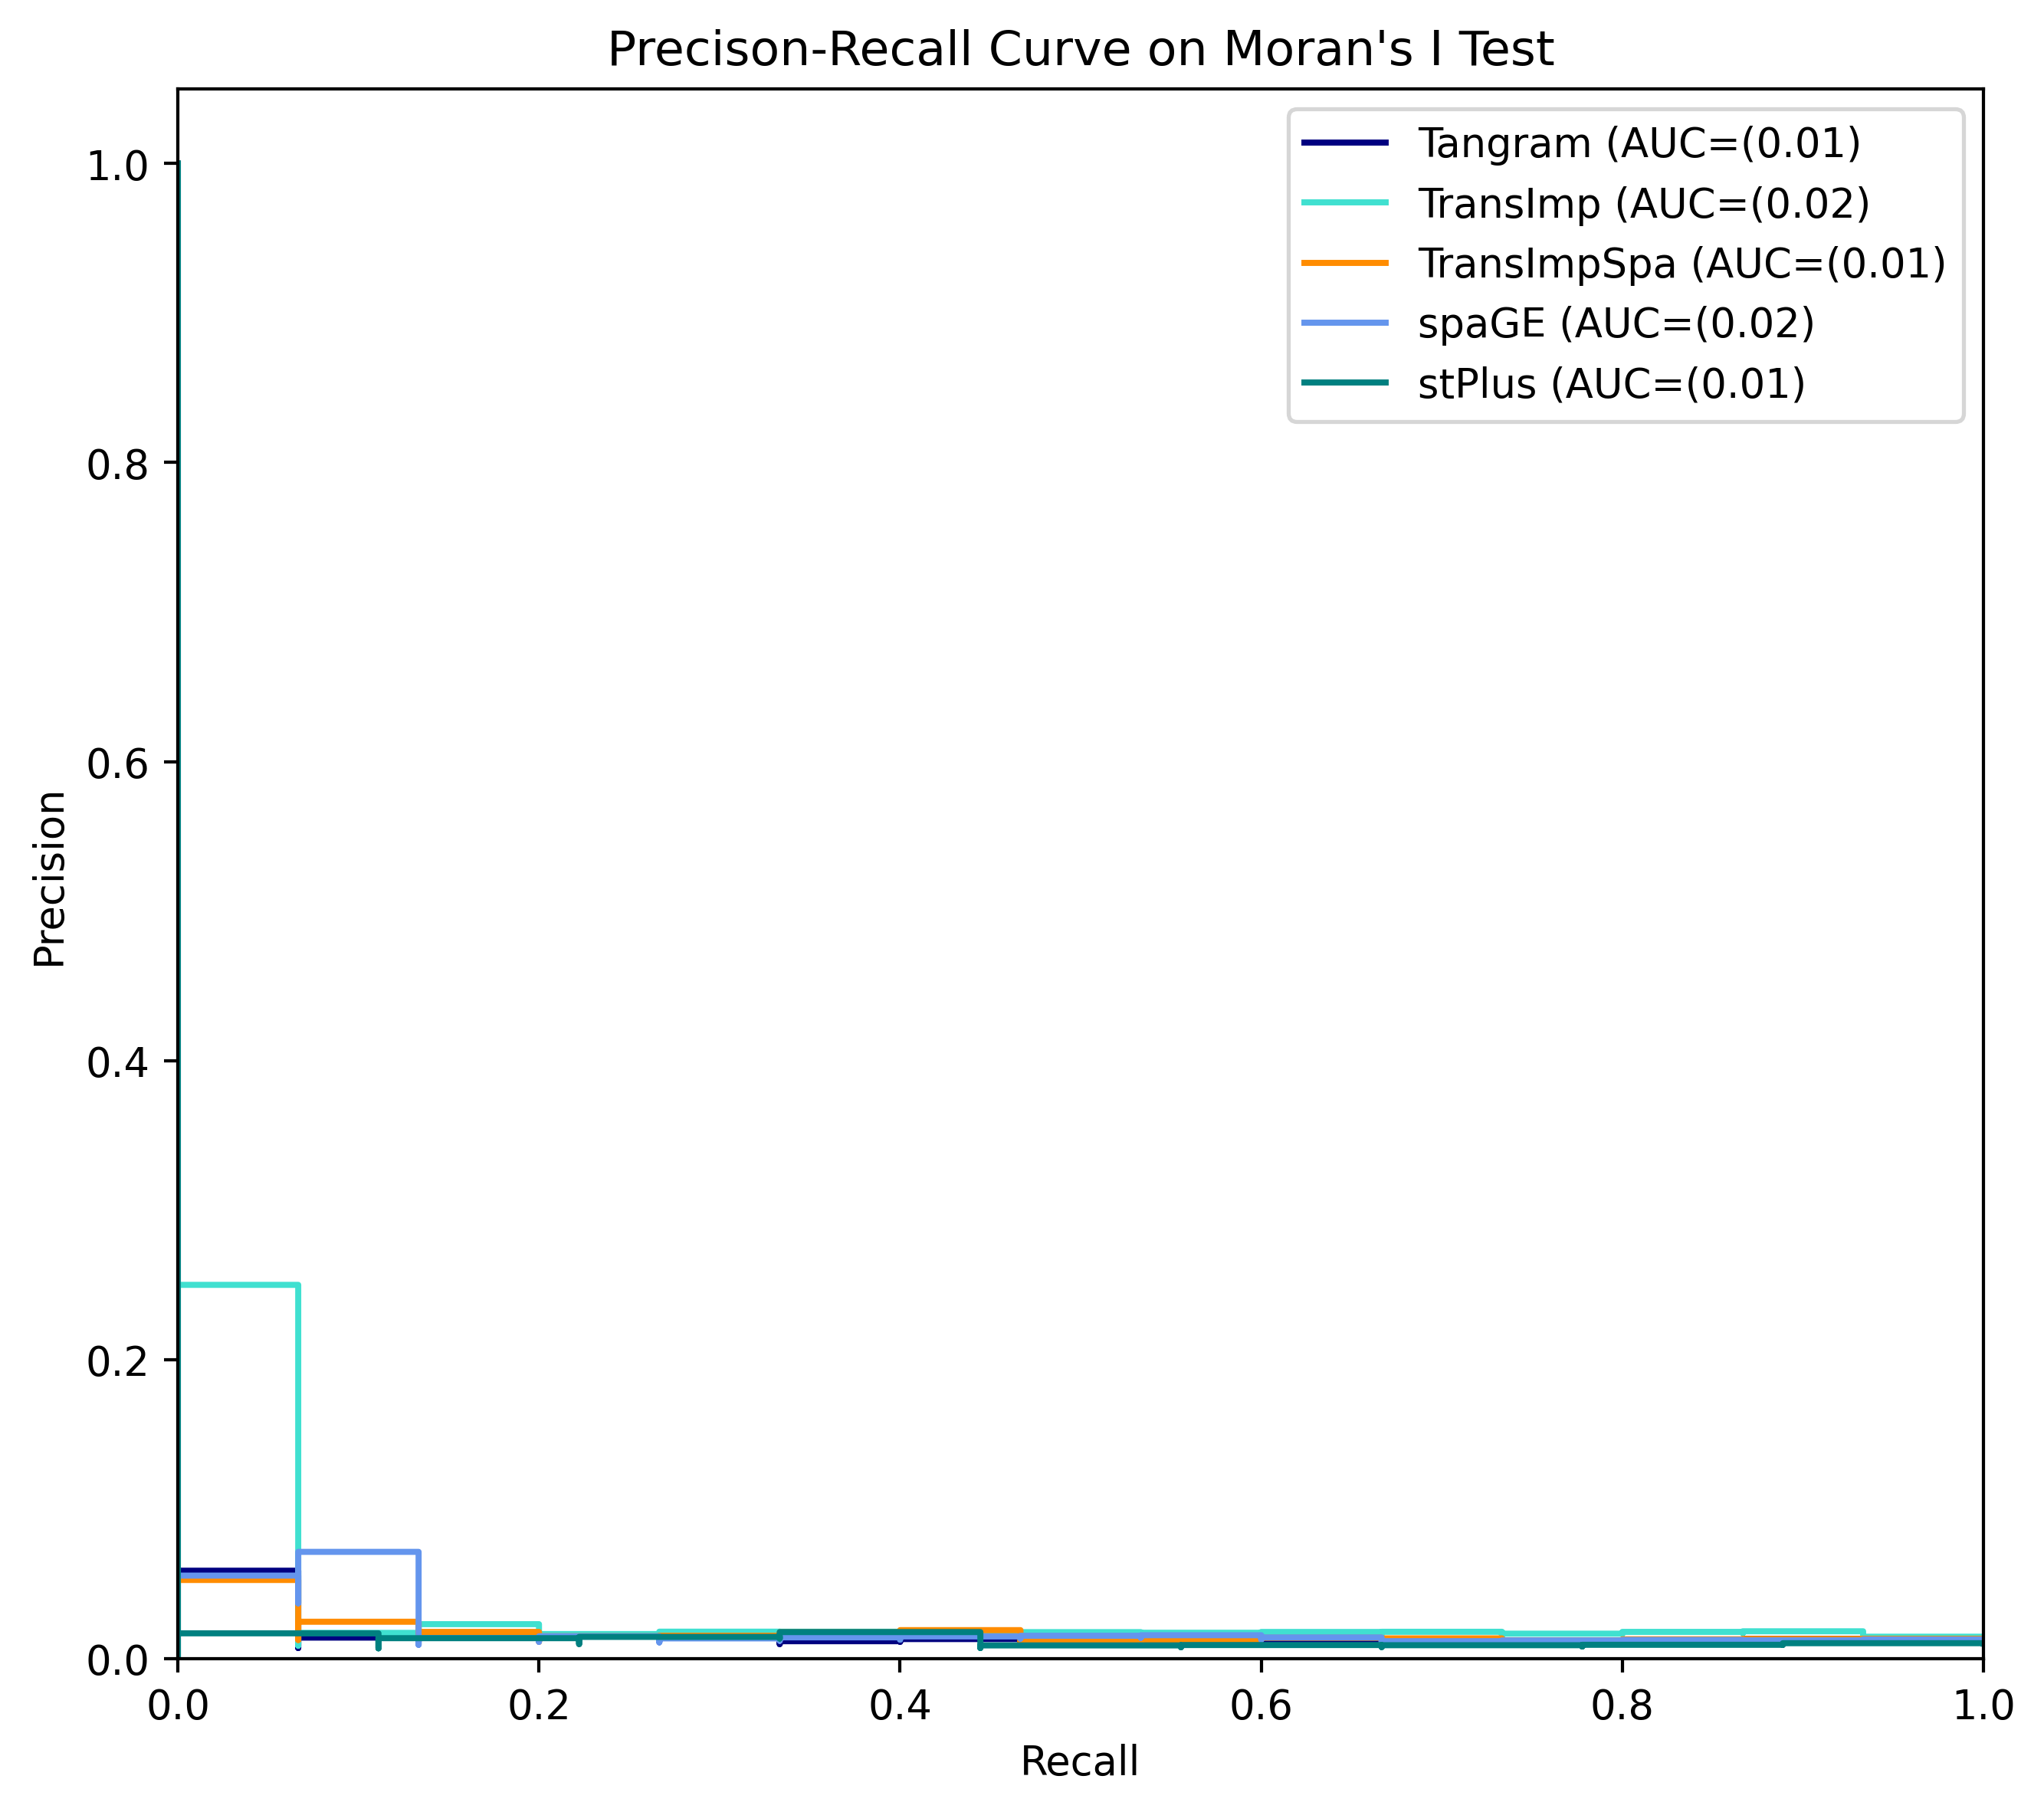

In [20]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred

    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    
    prec, rec, thresholds  = metrics.precision_recall_curve(y < thred, I, pos_label=1)
    
    auc_score = metrics.auc(rec, prec)
    
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({auc_score:.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 1190/3643
Tangram
FPR: 0.678298
(TransImp) Valid genes: 1190/3643
TransImp
FPR: 0.914043
(TransImpSpa) Valid genes: 1190/3643
TransImpSpa
FPR: 0.736170
(spaGE) Valid genes: 1190/3643
spaGE
FPR: 0.386383
(stPlus) Valid genes: 894/3643
stPlus
FPR: 0.000000


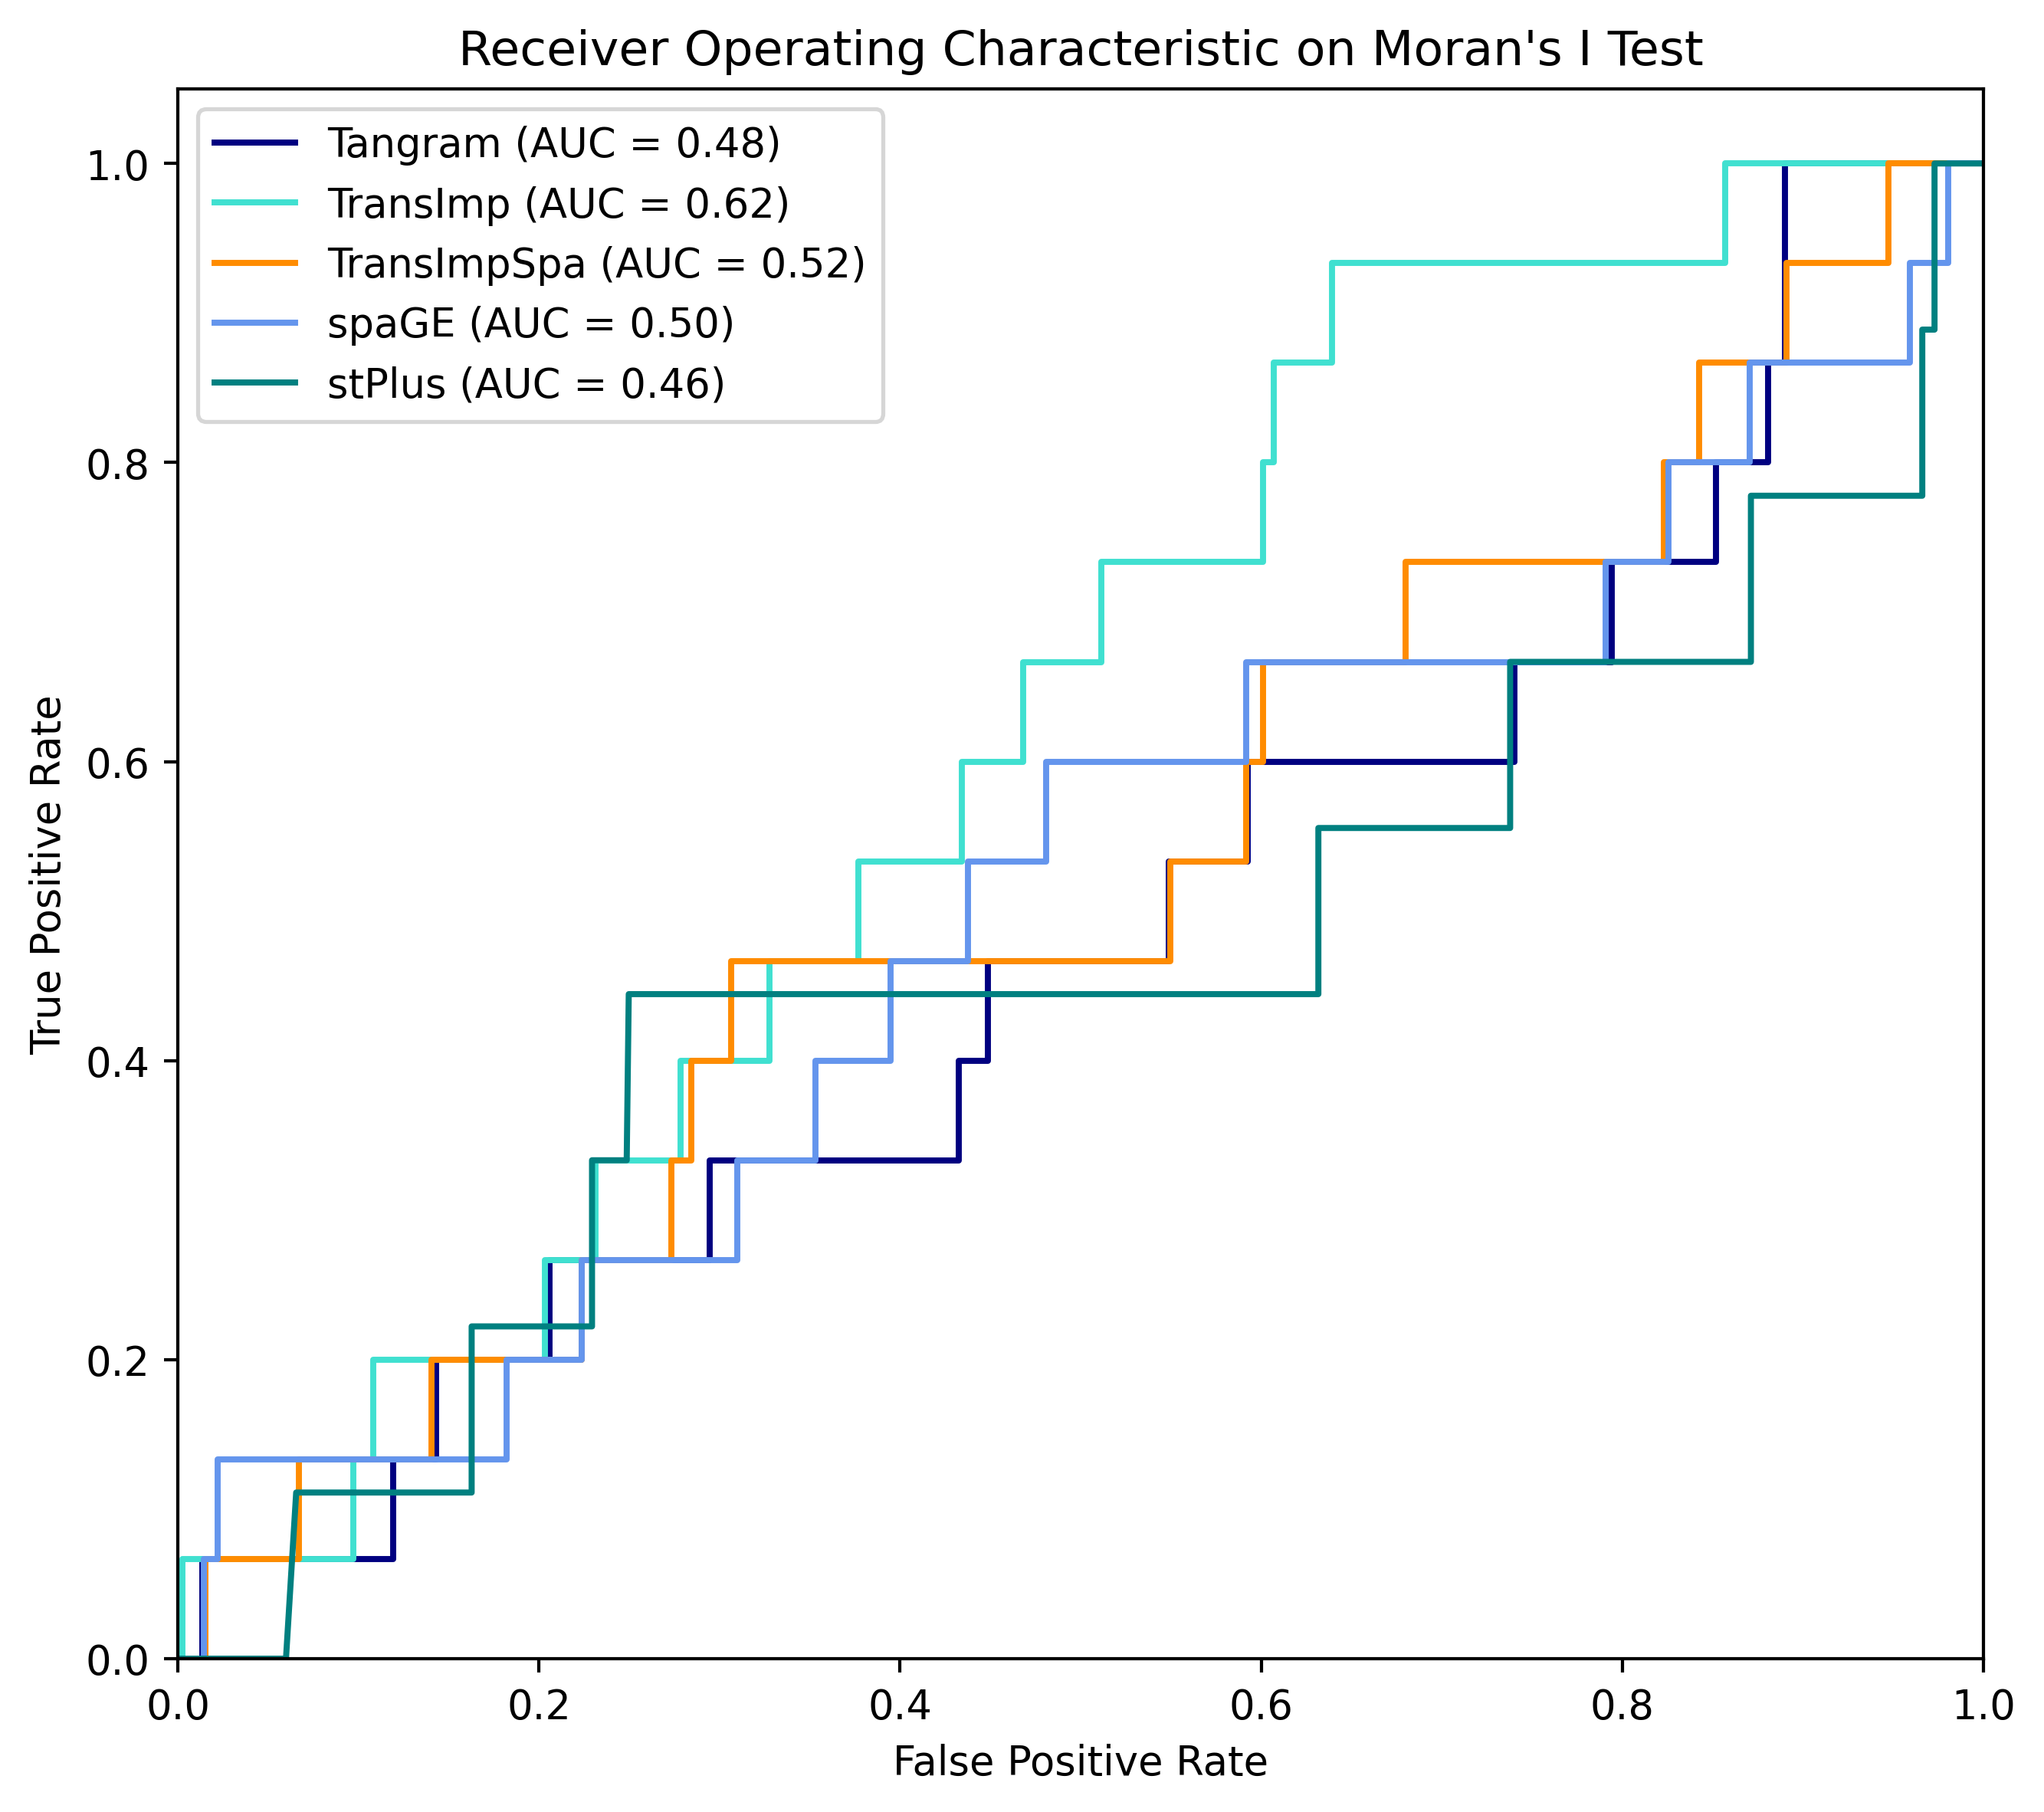

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [21]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    fpr, tpr, thresholds  = metrics.roc_curve(y < thred, I, pos_label=1)
    
    auc_score = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {auc_score:.2f})", color=color[idx])
    


ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 1190/3643
Tangram
FPR: 0.678298
prec: 0.012391573729863693, recl: 0.6666666666666666,  F1: 0.024330900243309004
(TransImp) Valid genes: 1190/3643
TransImp
FPR: 0.914043
prec: 0.011959521619135235, recl: 0.8666666666666667,  F1: 0.023593466424682397
(TransImpCls) Valid genes: 1190/3643
TransImpCls
FPR: 0.708085
prec: 0.013048635824436536, recl: 0.7333333333333333,  F1: 0.02564102564102564
(TransImpClsSpa) Valid genes: 1190/3643
TransImpClsSpa
FPR: 0.542979
prec: 0.010852713178294573, recl: 0.4666666666666667,  F1: 0.02121212121212121
(TransImpSpa) Valid genes: 1190/3643
TransImpSpa
FPR: 0.736170
prec: 0.012557077625570776, recl: 0.7333333333333333,  F1: 0.024691358024691357
(spaGE) Valid genes: 1190/3643
spaGE
FPR: 0.386383
prec: 0.008733624454148471, recl: 0.26666666666666666,  F1: 0.01691331923890063
(stPlus) Valid genes: 894/3643
stPlus
FPR: 0.000000
prec: 0.0, recl: 0.0,  F1: 0.0


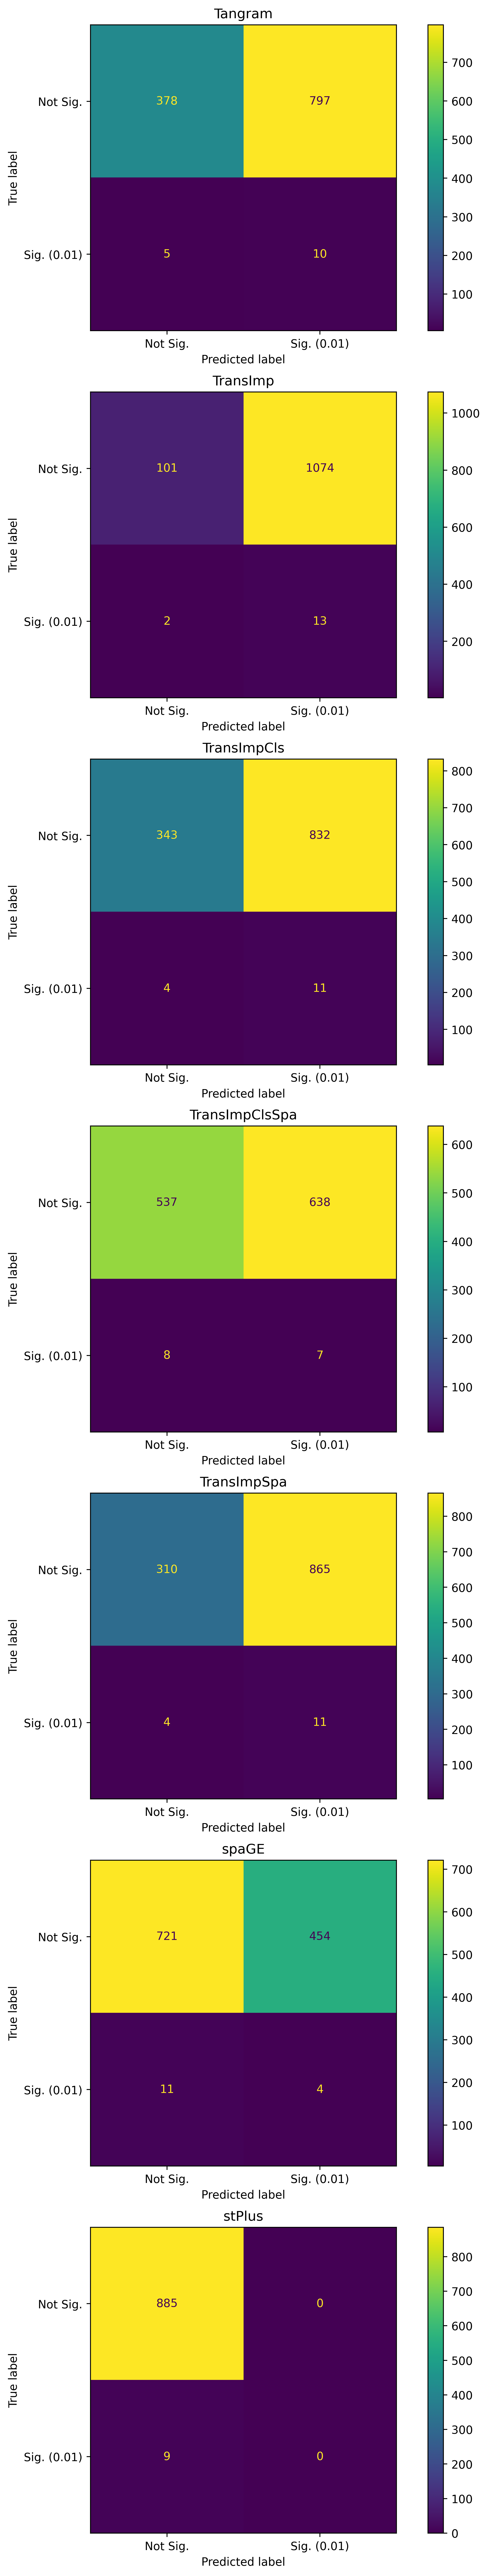

In [22]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(y < thred, preds)}, recl: {metrics.recall_score(y < thred, preds)},  F1: {metrics.f1_score(y < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [23]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r mouseliver

[1] "transImpute"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 7758 
## number of total genes: 3643 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "transImpSpa"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 7758 
## number of total genes: 3643 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
##

In [24]:
methods = ["truth", "transImpute", "transImpSpa", "transImpCls", "transImpClsSpa", "spaGE", "stPlus", "Tangram"]
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None
name_mapping = {"transImpute":"TransImp", "transImpSpa":"TransImpSpa", "transImpCls":"TransImpCls", "transImpClsSpa":"TransImpClsSpa"}
for md in methods:
    df = pd.read_csv(f"../../output/sparkx_mouseliver_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    if md in name_mapping:
        md = name_mapping[md]
    
    diff_genes = np.setdiff1d(ca_genes, df.index.values)
    if len(diff_genes) > 0:
        df = df.append(pd.DataFrame(np.ones((len(diff_genes), df.shape[1])), index=diff_genes, columns=df.columns))
        
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

(                        truth       TransImp    TransImpSpa    TransImpCls  \
 X0610005C13Rik   4.037593e-02   1.852467e-43   1.870938e-84   6.842684e-56   
 X0610031O16Rik   8.375872e-09   1.159201e-84  3.179702e-114   1.028274e-56   
 X1110032A03Rik   1.511411e-07   8.089895e-90   6.975709e-99  3.376046e-151   
 X1110046J04Rik   7.341508e-01   2.550910e-75  3.009620e-115  1.226978e-145   
 X1190005I06Rik   2.421696e-08   1.229584e-32   1.599265e-18   1.898821e-57   
 ...                       ...            ...            ...            ...   
 Zyg11b           7.936234e-31  2.031871e-116  2.767684e-136  4.937287e-213   
 mt.Atp8          7.622210e-08  7.651186e-140  3.259916e-162  1.920411e-214   
 mt.Nd2          6.291562e-101  3.415831e-140  5.996764e-163  7.473164e-217   
 mt.Nd3           4.164988e-23  5.319400e-151  2.886189e-172  2.699499e-222   
 mt.Nd6           9.102633e-01  2.999206e-112  7.083294e-132  6.843108e-220   
 
                 TransImpClsSpa         spaGE     

(Tangram) Valid genes: 3643/3643
Tangram
FPR: 0.942063
(TransImp) Valid genes: 3643/3643
TransImp
FPR: 0.974508
(TransImpSpa) Valid genes: 3643/3643
TransImpSpa
FPR: 0.976825
(spaGE) Valid genes: 3643/3643
spaGE
FPR: 0.787949
(stPlus) Valid genes: 3643/3643
stPlus
FPR: 0.333720


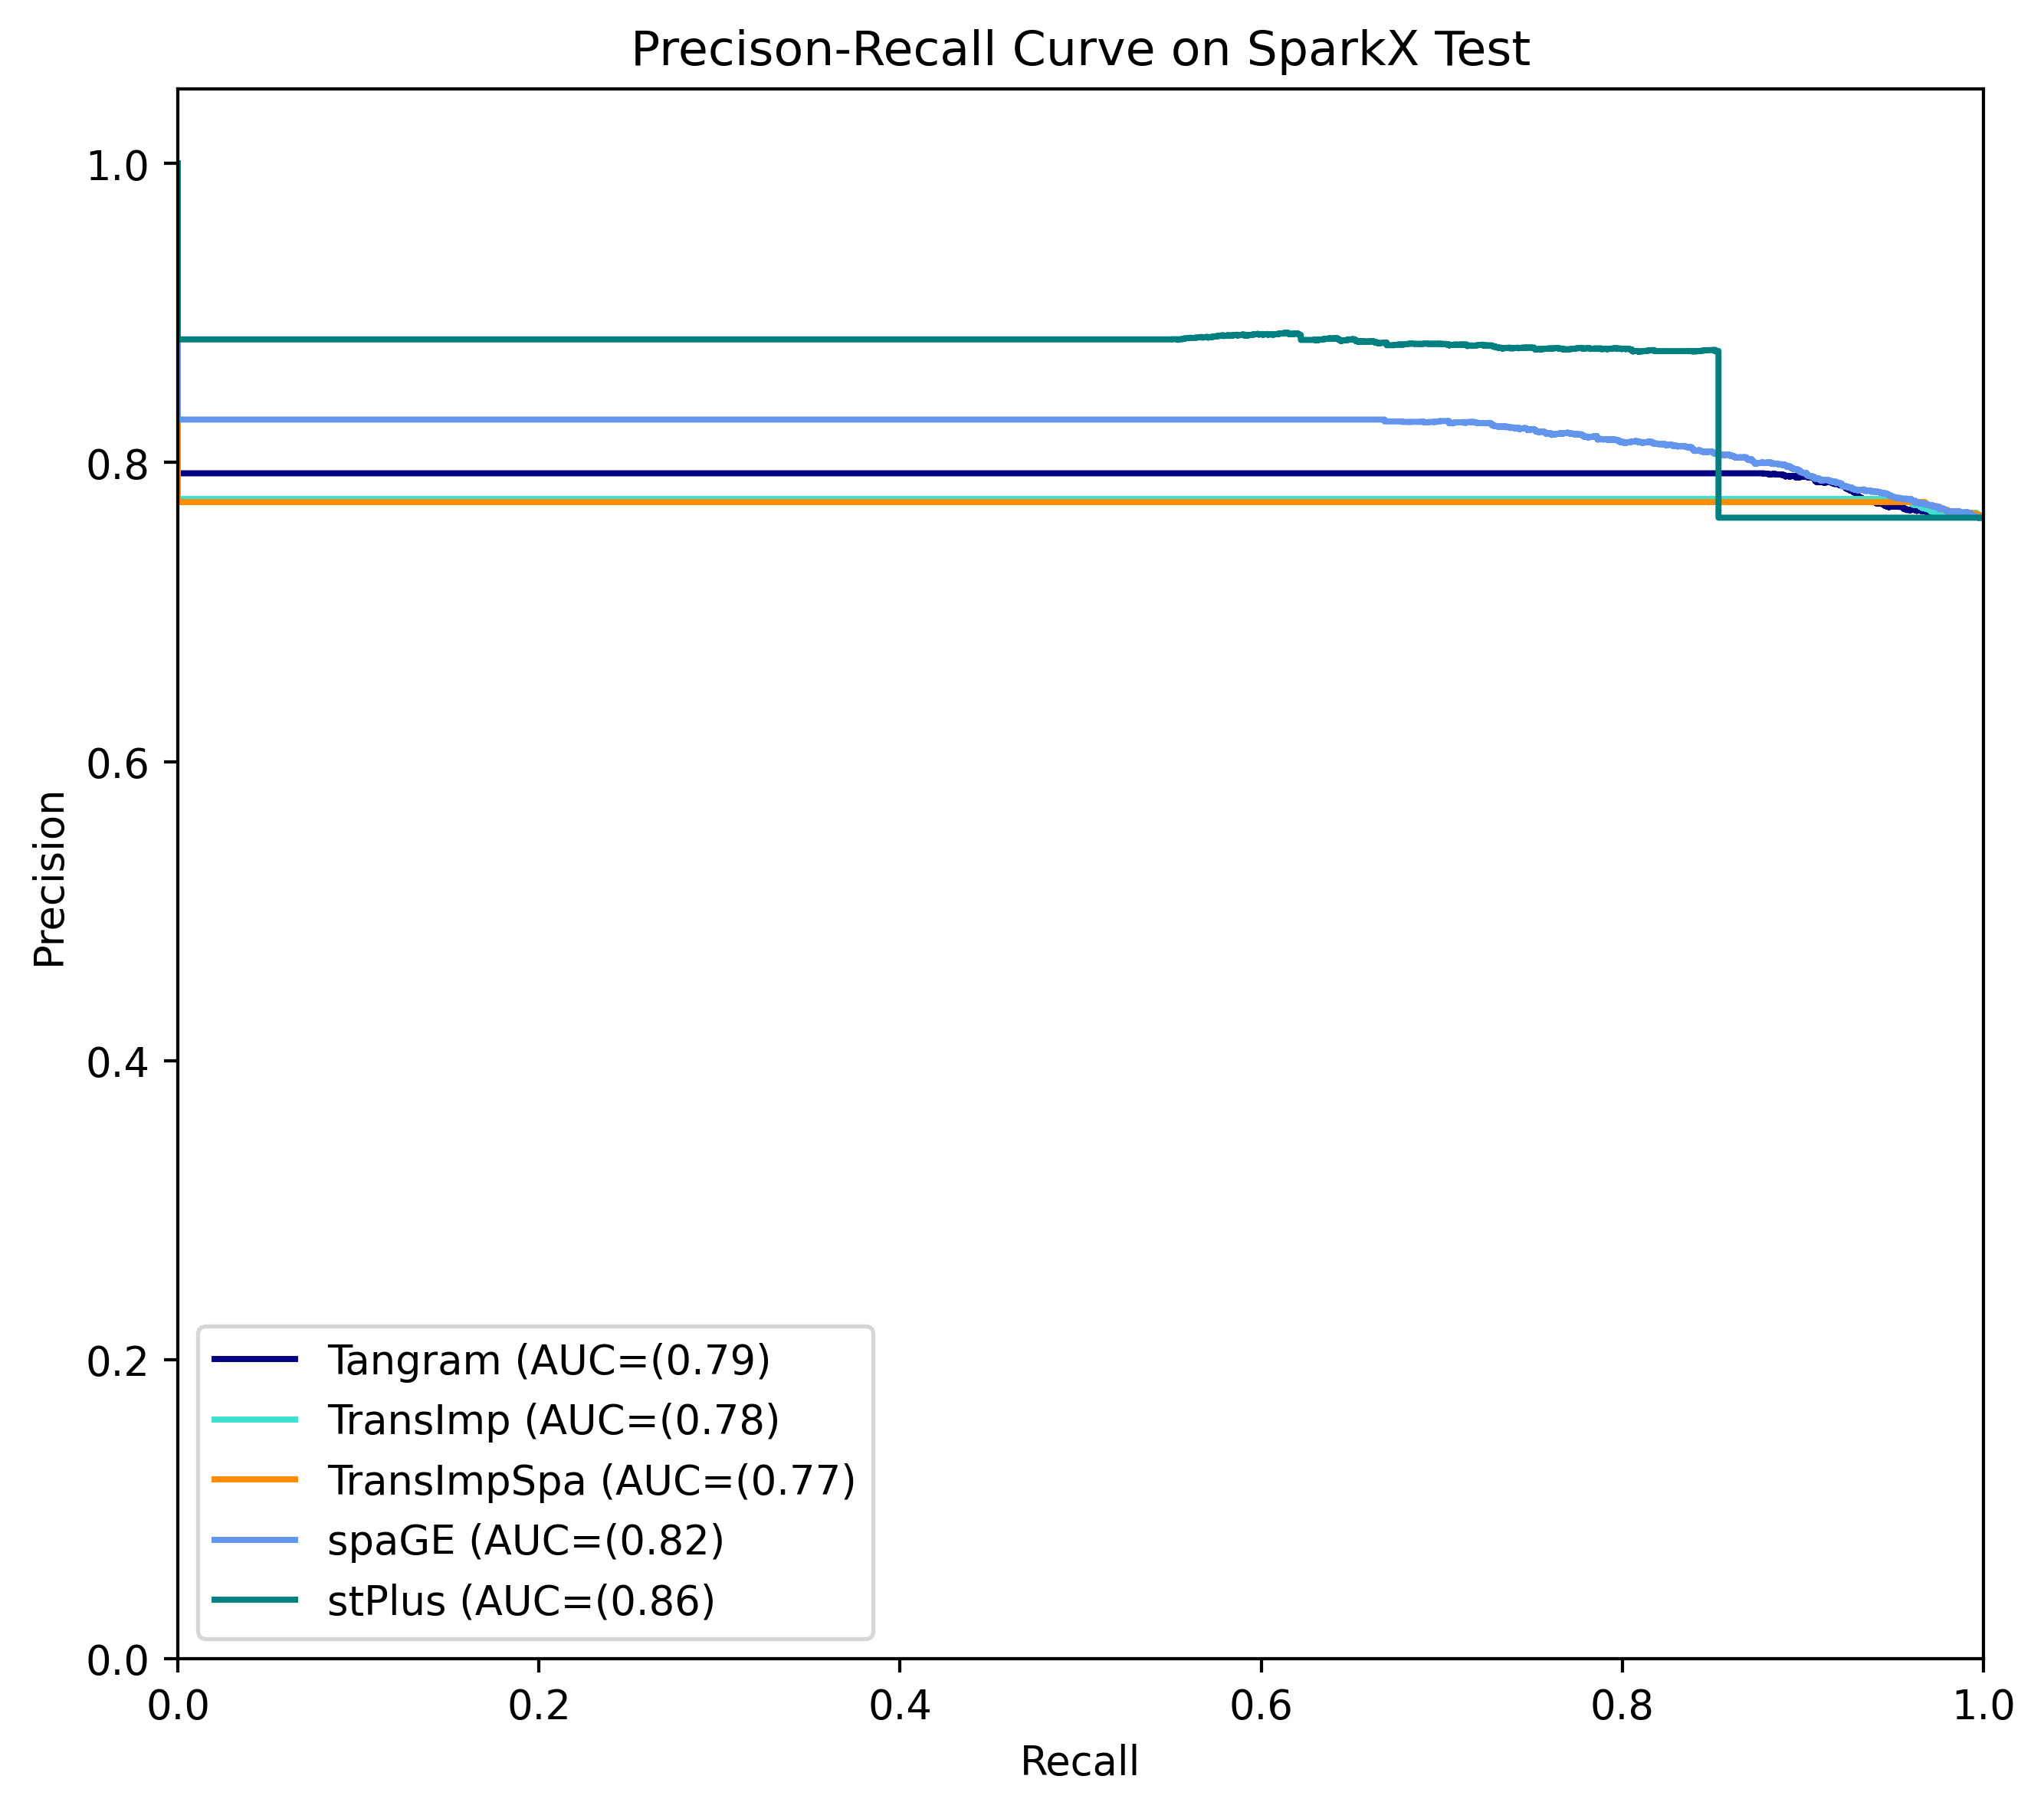

In [25]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_adjpvals[method][sel].values
    score = 1 - df_sparkx_cmbpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
    
        
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
        
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 3643/3643
Tangram
FPR: 0.942063
(TransImp) Valid genes: 3643/3643
TransImp
FPR: 0.974508
(TransImpSpa) Valid genes: 3643/3643
TransImpSpa
FPR: 0.976825
(spaGE) Valid genes: 3643/3643
spaGE
FPR: 0.787949
(stPlus) Valid genes: 3643/3643
stPlus
FPR: 0.333720


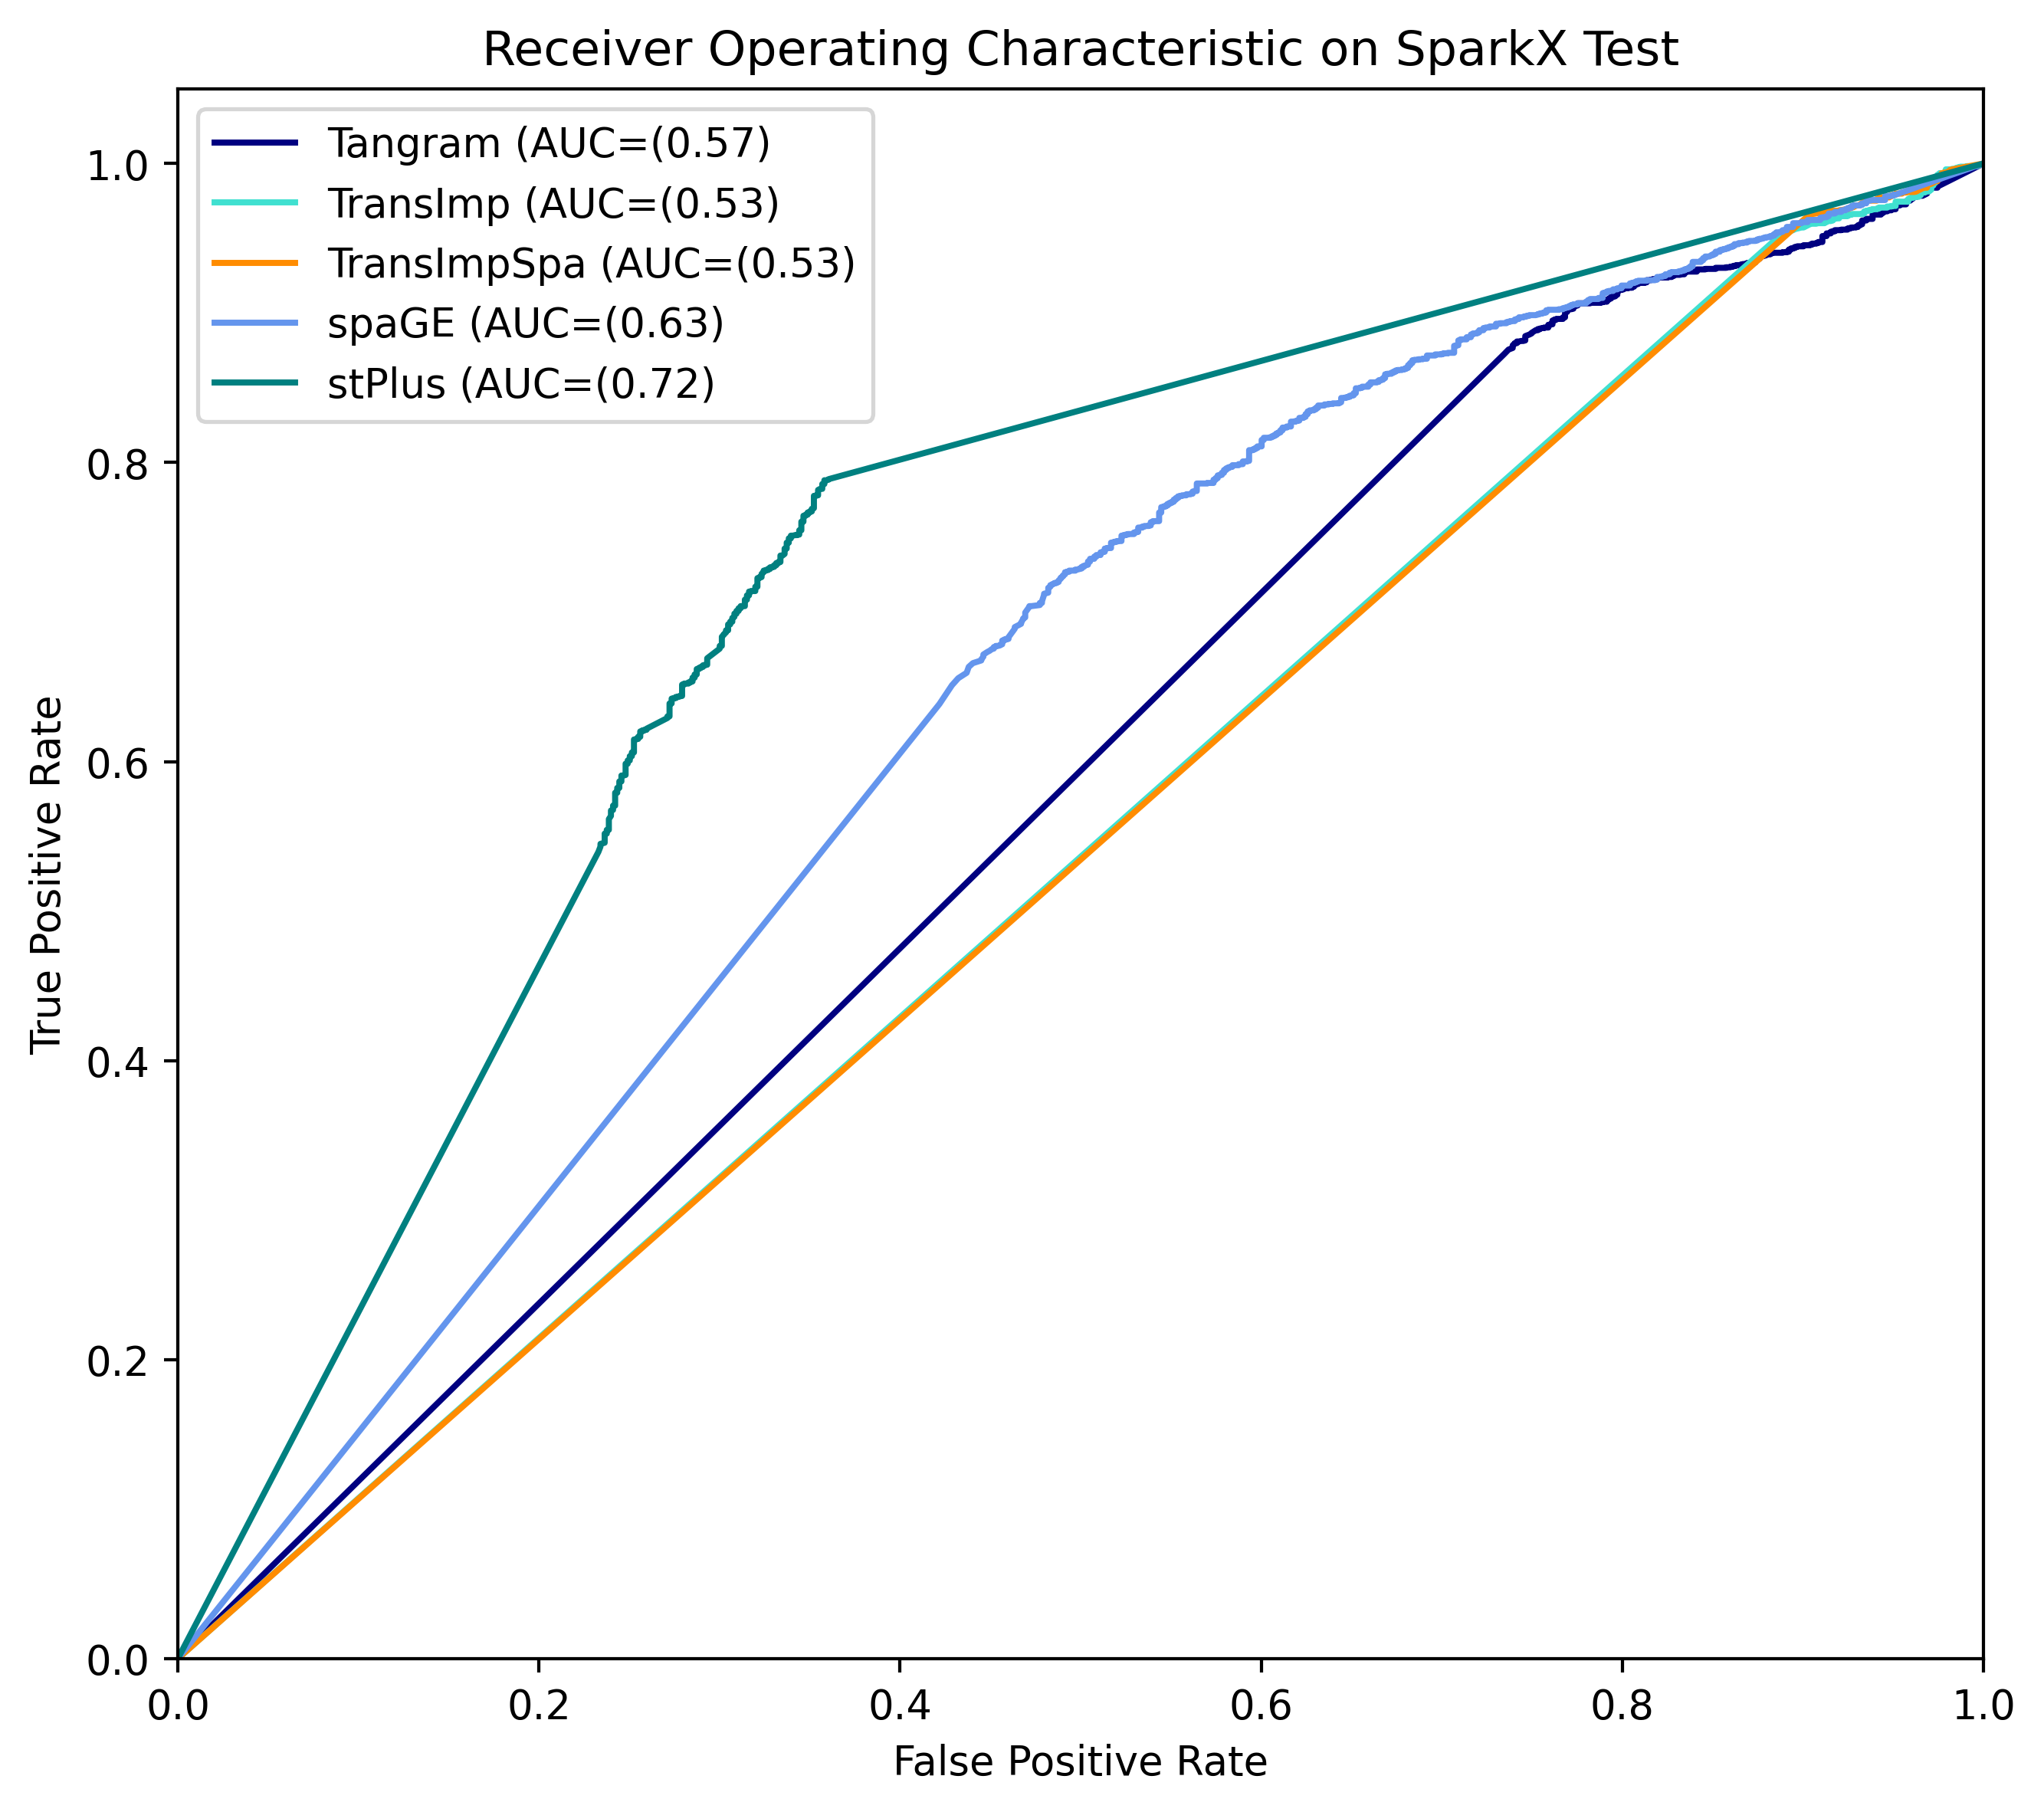

In [26]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 3643/3643
Tangram
FPR: 0.942063
prec: 0.7675814751286449, recl: 0.9658273381294964,  F1: 0.8553679515769353
(TransImp) Valid genes: 3643/3643
TransImp
FPR: 0.974508
prec: 0.7663239788830231, recl: 0.9920863309352518,  F1: 0.8647123373569524
(TransImpCls) Valid genes: 3643/3643
TransImpCls
FPR: 0.946698
prec: 0.7715963097567794, recl: 0.9928057553956835,  F1: 0.8683341198678621
(TransImpClsSpa) Valid genes: 3643/3643
TransImpClsSpa
FPR: 0.959444
prec: 0.7694235588972431, recl: 0.9938848920863309,  F1: 0.8673677601632398
(TransImpSpa) Valid genes: 3643/3643
TransImpSpa
FPR: 0.976825
prec: 0.765768268963601, recl: 0.9913669064748202,  F1: 0.864085279824424
(spaGE) Valid genes: 3643/3643
spaGE
FPR: 0.787949
prec: 0.7881619937694704, recl: 0.9100719424460432,  F1: 0.8447412353923204
(stPlus) Valid genes: 3643/3643
stPlus
FPR: 0.333720
prec: 0.8762354963472282, recl: 0.733453237410072,  F1: 0.7985118464852164


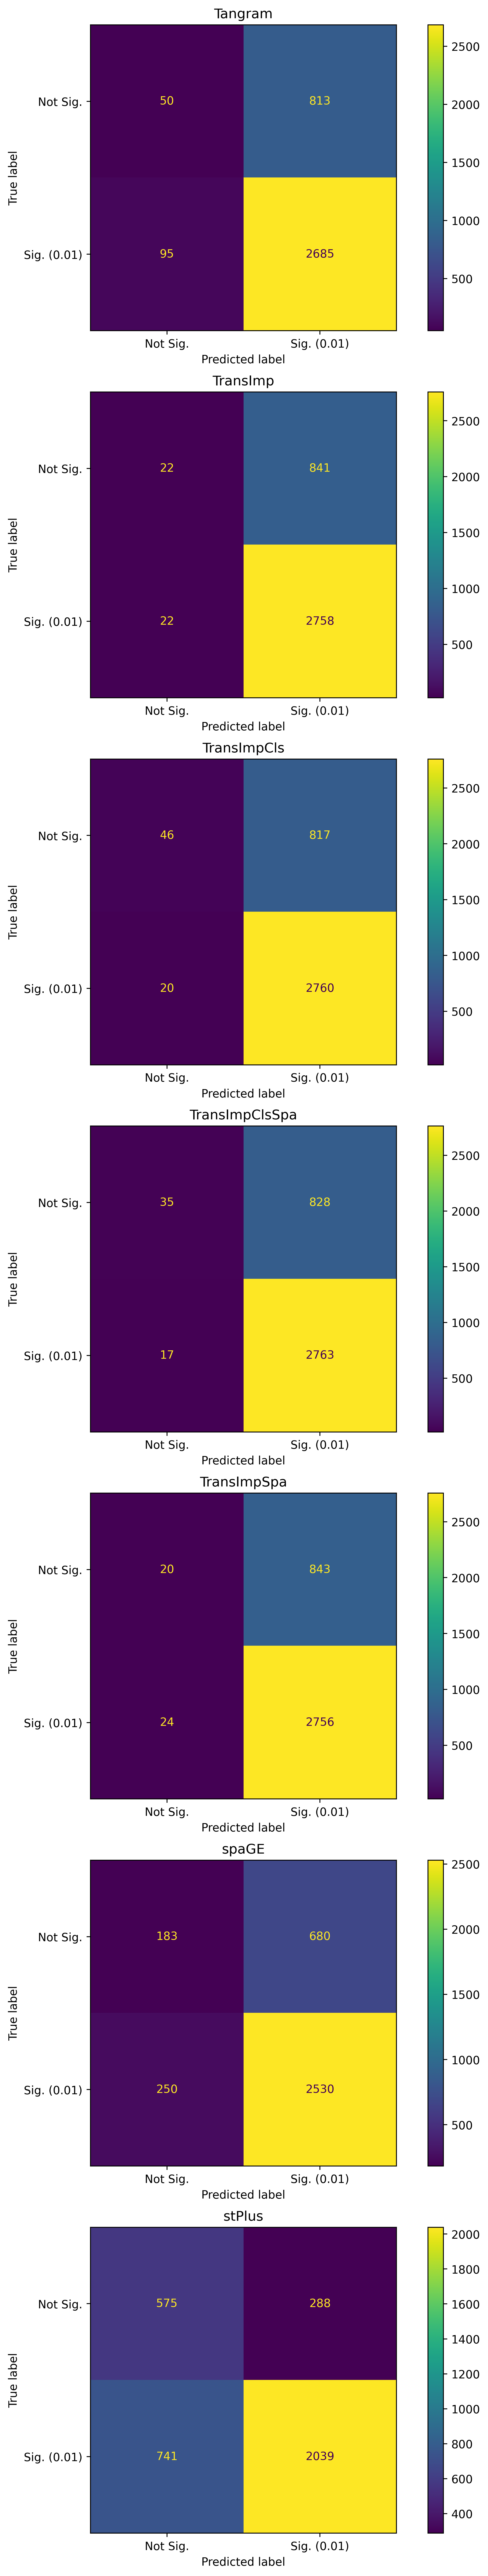

In [27]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()